
# 🧪 Autonomous Activity: Dimensionality Reduction on Embryo Development Timelapse

In this hands-on activity, you will apply a variety of dimensionality reduction techniques to analyze real microscopy data. The dataset contains time-lapse images of normal and mutant embryos. Each image stack has approximately 450 frames.

---

**🎯 Objectives:**
- Explore, visualize, and preprocess multi-frame `.tif` images.
- Test and compare different data normalization strategies (e.g., [0,1] scaling vs StandardScaler).
- Use PCA, SVD, t-SNE, UMAP, and Autoencoders to extract and visualize developmental trajectories.
- Identify biological differences in developmental dynamics between embryo types.
- Reflect on the advantages, limitations, and behaviors of each technique.

📁 **Dataset:** [Google Drive Link](https://drive.google.com/drive/folders/1_qxqm-v5yCrme3pAW2rjyOOXIeQDuV54?usp=drive_link)



## 1. Load and Explore the Dataset

Each `.tif` file contains ~450 grayscale frames. Your first task is to:
- Load the 3 `.tif` files using `tifffile.imread`.
- Normalize each image stack using two strategies:
  - [0, 1] Min-Max normalization
  - Standardization using `StandardScaler`
- Plot a few representative frames across time for each embryo.


Control image mean: 41.690775555555554
Control image std: 68.79471248349972
Control image shape: (450, 200, 200)


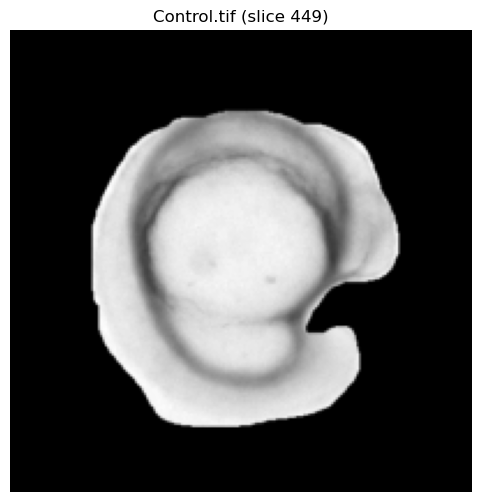

In [40]:
from pathlib import Path
from tifffile import imread
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

nimg = 0
tif_paths = [
    Path("Control.tif"),
    Path("Mutatnt1.tif"),
    Path("Mutatnt2.tif"),
]

control_image = imread(tif_paths[nimg])
std_control = np.std(control_image)
mean_control = np.mean(control_image)


print(f"Control image mean: {mean_control}")
print(f"Control image std: {std_control}")  
print(f"Control image shape: {control_image.shape}")

#print(control_image)

# --- Mostrar imagen ---
plt.figure(figsize=(6,6))

slice_idx = control_image.shape[0]-1
plt.imshow(control_image[slice_idx, :, :], cmap="gray")
plt.title(f"Control.tif (slice {slice_idx})")

plt.axis("off")
plt.show()



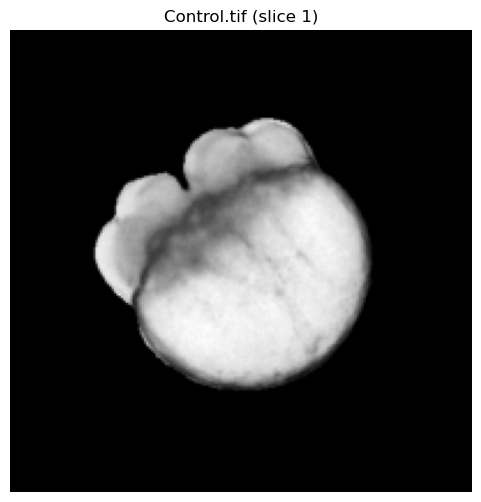

In [41]:
# control_image = imread(tif_paths[0])

arr = np.array(control_image).astype(np.float32)


for i in range(arr.shape[nimg]):
    min = np.min(arr[i, :, :])
    max = np.max(arr[i, :, :])
    arr[i, :, :] = (arr[i, :, :] - min) / (max - min)

plt.figure(figsize=(6,6))

slice_idx = arr.shape[0]-449
plt.imshow(arr[slice_idx, :, :] , cmap="gray")
plt.title(f"Control.tif (slice {slice_idx})")

plt.axis("off")
plt.show()

#salida arr matriz corresponde a todos los slices de la imagen control con normalizacion 0-1


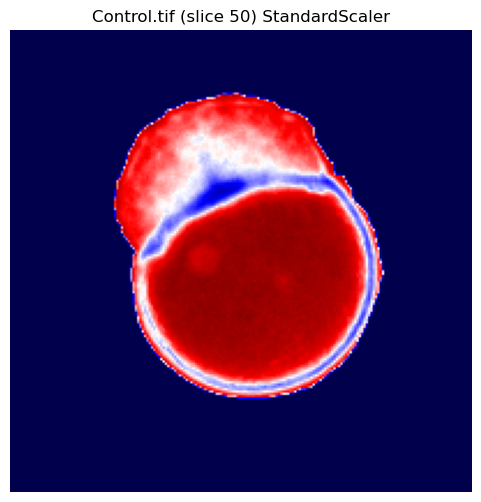

Media slice 50: 0.0000
Std slice 50: 1.0000


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Convertir a float32
arr = np.array(control_image).astype(np.float32)

# Preparar salida con la misma forma
std_img = np.empty_like(arr, dtype=np.float32)

scaler = StandardScaler()

# Normalización Z-score slice por slice
for i in range(arr.shape[0]):
    flat = arr[i, :, :].reshape(-1, 1)   # aplanar slice
    scaled_flat = scaler.fit_transform(flat)
    std_img[i, :, :] = scaled_flat.reshape(arr[i, :, :].shape)

# Mostrar un slice de la imagen estandarizada
slice_idx = arr.shape[0] - 400   # usar slice central como ejemplo
plt.figure(figsize=(6,6))
plt.imshow(std_img[slice_idx, :, :], cmap="seismic")  # colormap divergente
plt.title(f"Control.tif (slice {slice_idx}) StandardScaler")
plt.axis("off")
plt.show()

print(f"Media slice {slice_idx}: {std_img[slice_idx].mean():.4f}")
print(f"Std slice {slice_idx}: {std_img[slice_idx].std():.4f}")

#std_img matriz estandarizada para control 




## 2. Preprocess the Data

Flatten each frame and construct a matrix `X` with shape `(n_frames, n_pixels)` for each normalization method. Then create a label vector:

- `label = 0` → control embryo
- `label = 1` → mutant 1
- `label = 2` → mutant 2

This step will prepare the input data for dimensionality reduction.



> 🧪 **Experiment**: Try running all dimensionality reduction methods with both versions of the input (`X_minmax` and `X_standard`) and compare how they affect embeddings and separability.


In [43]:


tif_paths = [
    Path("Control.tif"),
    Path("Mutatnt1.tif"),
    Path("Mutatnt2.tif"),
]

# --- Cargar el primer stack para definir dimensiones ---
first = imread(tif_paths[0]).astype(np.float32)
if first.ndim != 3:
    raise ValueError(f"Esperaba (n_frames, H, W); recibido {first.shape}")

n_frames, H, W = first.shape
n_stacks = len(tif_paths)

# --- Contenedores ---
arr2       = np.empty((n_frames, H, W, n_stacks), dtype=np.float32)  # datos brutos
arr_minmax = np.empty_like(arr2, dtype=np.float32)                   # salida min-max por frame
arr_zscore = np.empty_like(arr2, dtype=np.float32)                   # salida z-score por frame

# --- Cargar todos los stacks verificando shapes ---
for j, tif_path in enumerate(tif_paths):
    grp = imread(tif_path).astype(np.float32)
    if grp.shape != (n_frames, H, W):
        raise ValueError(f"{tif_path} shape {grp.shape} != {(n_frames, H, W)}")
    arr2[..., j] = grp

# --- Normalización por frame (slice 2D) para cada stack ---
for j in range(n_stacks):
    for i in range(n_frames):
        img = arr2[i, :, :, j]  # (H, W)

        # -------- Min-Max [0,1] por frame --------
        vmin = float(np.min(img))
        vmax = float(np.max(img))
        if vmax > vmin:
            arr_minmax[i, :, :, j] = (img - vmin) / (vmax - vmin)
        else:
            # frame constante -> todo a 0
            arr_minmax[i, :, :, j] = 0.0

        # -------- Z-score por frame (media 0, var 1) --------
        flat = img.reshape(-1, 1)                # (H*W, 1)
        scaler = StandardScaler()
        scaled_flat = scaler.fit_transform(flat).astype(np.float32)
        arr_zscore[i, :, :, j] = scaled_flat.reshape(H, W)

In [45]:

n1 = arr_minmax
n2 = arr_zscore
print(n2.shape)
print(n1.shape)

(450, 200, 200, 3)
(450, 200, 200, 3)


In [24]:
import numpy as np

# arr2:      (n_frames, H, W, n_stacks)  # crudo
# arr_minmax:(n_frames, H, W, n_stacks)  # min-max por frame
# arr_zscore:(n_frames, H, W, n_stacks)  # z-score por frame

n_frames, H, W, n_stacks = arr2.shape
n_pixels = H * W

# --- Construir X por método y vector de etiquetas (0,1,2) ---
Xs_raw, Xs_minmax, Xs_zscore = [], [], []
y = []

for j in range(n_stacks):
    # Aplana cada frame del stack j -> (n_frames, n_pixels)
    X_raw_j    = arr2[:, :, :, j].reshape(n_frames, n_pixels).astype(np.float32)
    X_minmax_j = arr_minmax[:, :, :, j].reshape(n_frames, n_pixels).astype(np.float32)
    X_zscore_j = arr_zscore[:, :, :, j].reshape(n_frames, n_pixels).astype(np.float32)

    Xs_raw.append(X_raw_j)
    Xs_minmax.append(X_minmax_j)
    Xs_zscore.append(X_zscore_j)

    # Etiquetas numéricas por frame (según orden de tif_paths)
    # 0 -> control, 1 -> mutant1, 2 -> mutant2
    y.extend([j] * n_frames)

# Concatenar todos los stacks (filas = frames)
X_raw    = np.vstack(Xs_raw)        # shape: (n_stacks*n_frames, n_pixels)
X_minmax = np.vstack(Xs_minmax)     # shape: (n_stacks*n_frames, n_pixels)
X_zscore = np.vstack(Xs_zscore)     # shape: (n_stacks*n_frames, n_pixels)
y = np.array(y, dtype=np.int64)     # shape: (n_stacks*n_frames,)

print("X_raw   :", X_raw.shape,   "X_minmax:", X_minmax.shape, "X_zscore:", X_zscore.shape)
print("y       :", y.shape, "clases en y:", np.unique(y))

X_raw   : (1350, 40000) X_minmax: (1350, 40000) X_zscore: (1350, 40000)
y       : (1350,) clases en y: [0 1 2]



## 3. PCA (Principal Component Analysis)

Apply PCA on both normalized datasets:
- Visualize the 2D PCA embedding colored by embryo type.
- Compare the separation between classes for `X_minmax` and `X_standard`.
- Plot the **explained variance ratio** and **cumulative variance** for each.

> 🧠 Tip: Use `PCA(n_components=2)` for plotting and `PCA(n_components=50)` to analyze cumulative variance.


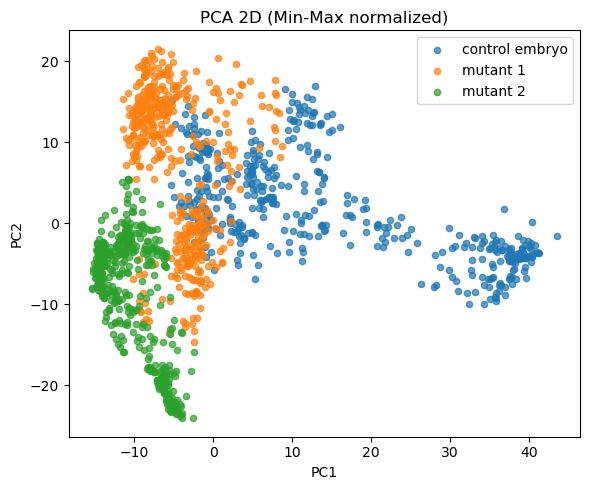

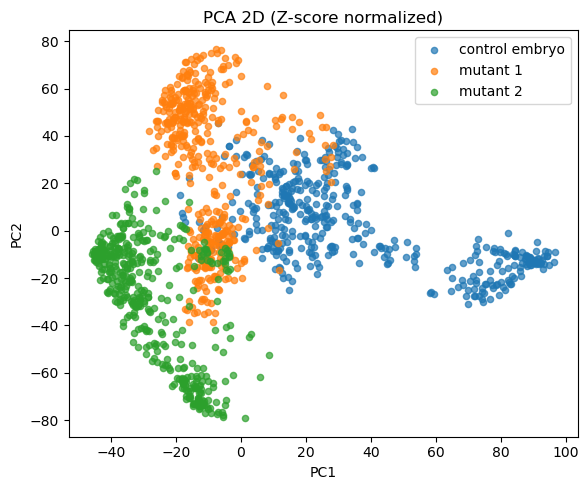

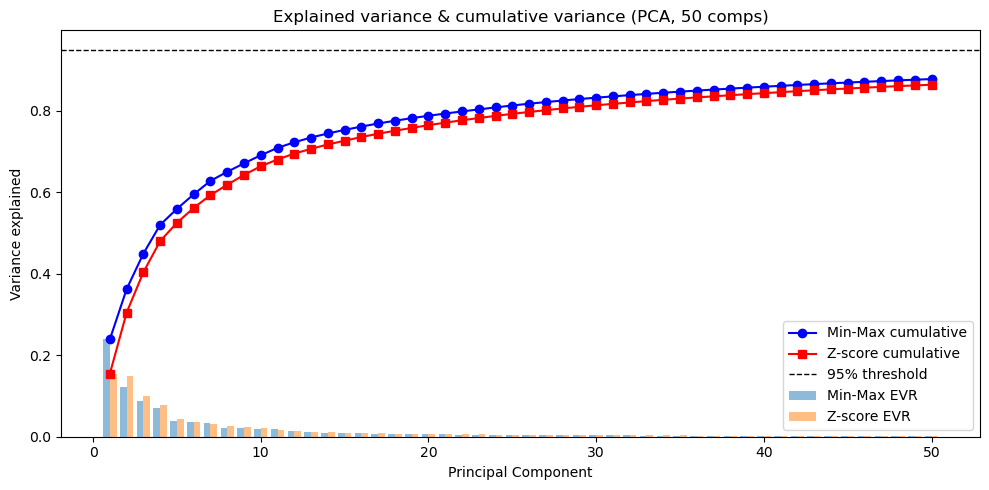

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# --- Definiciones ---
label_names = {0: "control embryo", 1: "mutant 1", 2: "mutant 2"}
colors = ["tab:blue", "tab:orange", "tab:green"]

# ================= PCA 2D para visualización =================
def plot_pca_scatter(X, y, title):
    pca2 = PCA(n_components=2, random_state=0)
    Z = pca2.fit_transform(X)

    plt.figure(figsize=(6,5))
    for label in np.unique(y):
        plt.scatter(
            Z[y==label, 0], Z[y==label, 1],
            label=label_names[label], alpha=0.7, s=20, color=colors[label]
        )
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualizar embeddings 2D
plot_pca_scatter(X_minmax, y, "PCA 2D (Min-Max normalized)")
plot_pca_scatter(X_zscore, y, "PCA 2D (Z-score normalized)")


def plot_variance_comparison(X_minmax, X_zscore, labels=("Min-Max", "Z-score")):
    # PCA con hasta 50 componentes
    pca_mm = PCA(n_components=50, random_state=0).fit(X_minmax)
    pca_zs = PCA(n_components=50, random_state=0).fit(X_zscore)

    var_mm = pca_mm.explained_variance_ratio_
    var_zs = pca_zs.explained_variance_ratio_

    cum_mm = np.cumsum(var_mm)
    cum_zs = np.cumsum(var_zs)

    pcs = np.arange(1, 51)

    plt.figure(figsize=(10,5))

    # --- Min-Max ---
    plt.bar(pcs-0.2, var_mm, width=0.4, alpha=0.5, label=f"{labels[0]} EVR")
    plt.plot(pcs, cum_mm, marker="o", color="blue", label=f"{labels[0]} cumulative")

    # --- Z-score ---
    plt.bar(pcs+0.2, var_zs, width=0.4, alpha=0.5, label=f"{labels[1]} EVR")
    plt.plot(pcs, cum_zs, marker="s", color="red", label=f"{labels[1]} cumulative")

    # --- Línea horizontal del 95% ---
    plt.axhline(0.95, linestyle="--", color="black", linewidth=1, label="95% threshold")

    plt.xlabel("Principal Component")
    plt.ylabel("Variance explained")
    plt.title("Explained variance & cumulative variance (PCA, 50 comps)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Llamar función
plot_variance_comparison(X_minmax, X_zscore)





## 4. SVD (Singular Value Decomposition)

Apply SVD to both datasets and analyze:
- The decay of singular values on a log scale.
- The cumulative energy of singular values.
- Compare how quickly each normalization captures energy.

> 🔍 Insight: SVD reveals the inherent structure of your dataset. A sharper drop often suggests stronger linear compressibility.


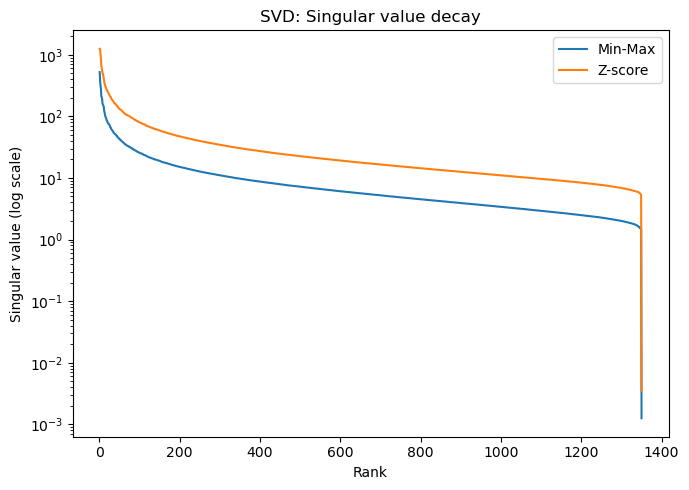

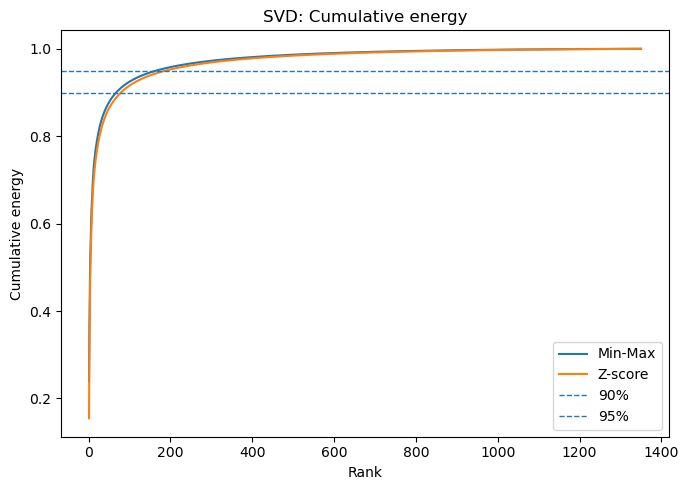

[Min-Max] rank @90%:   68, rank @95%:  165
[Z-score] rank @90%:   79, rank @95%:  188


In [28]:
import numpy as np
import matplotlib.pyplot as plt

# ========= Helpers =========
def center_columns(X):
    """Centra columnas: resta la media de cada feature."""
    return X - X.mean(axis=0, keepdims=True)

def svd_energy(X):
    """
    Realiza SVD económico y devuelve:
      s: valores singulares (ordenados desc)
      e: energía por componente (s^2)
      ecum: energía acumulada normalizada (0..1)
    """
    # Convertimos a float64 por estabilidad numérica
    X = np.asarray(X, dtype=np.float64)
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    e = s**2
    ecum = np.cumsum(e) / np.sum(e)
    return s, e, ecum

def rank_for_threshold(ecum, thr=0.90):
    """Índice (1-based) del primer rank que alcanza el umbral de energía acumulada."""
    return int(np.searchsorted(ecum, thr) + 1)

# ========= Preparación: centrar columnas =========
Xmm_c = center_columns(X_minmax)
Xzs_c = center_columns(X_zscore)

# ========= SVD en ambos conjuntos =========
s_mm, e_mm, ecum_mm = svd_energy(Xmm_c)
s_zs, e_zs, ecum_zs = svd_energy(Xzs_c)

rmax = np.minimum(s_mm.shape[0], s_zs.shape[0])  # comparación justa

# ========= 1) Decaimiento de valores singulares (log) =========
plt.figure(figsize=(7,5))
plt.semilogy(np.arange(1, rmax+1), s_mm[:rmax], label="Min-Max")
plt.semilogy(np.arange(1, rmax+1), s_zs[:rmax], label="Z-score")
plt.xlabel("Rank")
plt.ylabel("Singular value (log scale)")
plt.title("SVD: Singular value decay")
plt.legend()
plt.tight_layout()
plt.show()

# ========= 2) Energía acumulada =========
plt.figure(figsize=(7,5))
plt.plot(np.arange(1, rmax+1), ecum_mm[:rmax], label="Min-Max")
plt.plot(np.arange(1, rmax+1), ecum_zs[:rmax], label="Z-score")
plt.axhline(0.90, linestyle="--", linewidth=1, label="90%")
plt.axhline(0.95, linestyle="--", linewidth=1, label="95%")
plt.xlabel("Rank")
plt.ylabel("Cumulative energy")
plt.title("SVD: Cumulative energy")
plt.legend()
plt.tight_layout()
plt.show()

# ========= 3) Métricas de compresibilidad (ranks @ 90% y 95%) =========
r90_mm = rank_for_threshold(ecum_mm, 0.90)
r95_mm = rank_for_threshold(ecum_mm, 0.95)
r90_zs = rank_for_threshold(ecum_zs, 0.90)
r95_zs = rank_for_threshold(ecum_zs, 0.95)

print(f"[Min-Max] rank @90%: {r90_mm:>4}, rank @95%: {r95_mm:>4}")
print(f"[Z-score] rank @90%: {r90_zs:>4}, rank @95%: {r95_zs:>4}")


## 5. t-SNE

Use t-SNE to capture local structure and dynamics:
- Run t-SNE with different perplexities `[5, 30, 100]`.
- Plot the 2D embeddings and analyze how clusters behave.
- Compare results between both normalized inputs.

> ⏳ Note: t-SNE is computationally intensive and sensitive to hyperparameters.


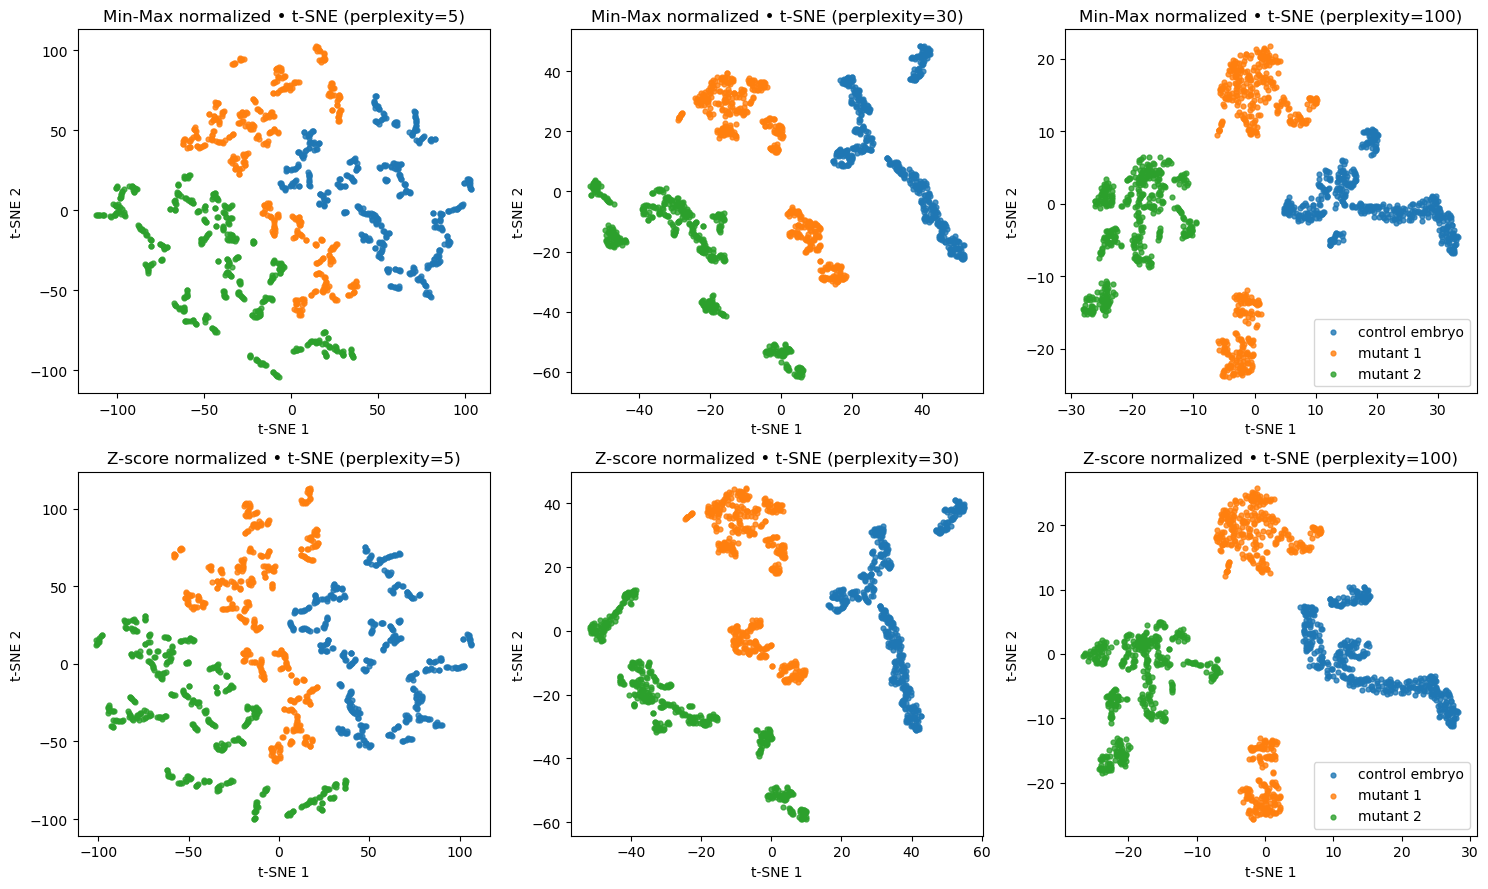

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import builtins as _b  # acceso seguro a min/max originales

# --- Config ---
perplexities = [5, 30, 100]
label_names = {0: "control embryo", 1: "mutant 1", 2: "mutant 2"}
colors = ["tab:blue", "tab:orange", "tab:green"]
random_state = 0

# --- Helpers ---
def safe_pca(X, k=50):
    n_samples, n_features = X.shape
    n_ok = _b.max(2, _b.min(k, n_samples - 1, n_features))
    return PCA(n_components=n_ok, random_state=random_state).fit_transform(X)

def run_tsne(X, perp, rs=0, lr="auto", max_iter=1500):
    n = X.shape[0]
    max_perp = _b.max(2, int(n // 3))
    perp_eff = _b.min(perp, max_perp, n - 2)
    tsne = TSNE(
        n_components=2,
        perplexity=perp_eff,
        learning_rate=lr,
        max_iter=max_iter,     # <-- cambio aquí
        init="pca",
        metric="euclidean",
        random_state=rs,
        verbose=0
    )
    Z = tsne.fit_transform(X)
    return Z, perp_eff

def plot_tsne_grid(X_list, titles, y, perplexities):
    rows, cols = len(X_list), len(perplexities)
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4.5*rows), squeeze=False)

    for r, (X, tname) in enumerate(zip(X_list, titles)):
        Xp = safe_pca(X, k=50)  # pre-PCA para acelerar t-SNE
        for c, perp in enumerate(perplexities):
            Z, perp_eff = run_tsne(Xp, perp, rs=random_state)
            ax = axes[r, c]
            for lab in np.unique(y):
                ax.scatter(
                    Z[y == lab, 0], Z[y == lab, 1],
                    s=12, alpha=0.8,
                    label=label_names[int(lab)],
                    color=colors[int(lab)]
                )
            ax.set_title(f"{tname} • t-SNE (perplexity={perp_eff})")
            ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")
            if c == cols - 1:
                ax.legend(loc="best")
    plt.tight_layout()
    plt.show()

# --- Ejecutar ---
X_sets  = [X_minmax, X_zscore]
titles  = ["Min-Max normalized", "Z-score normalized"]
plot_tsne_grid(X_sets, titles, y, perplexities)


## 6. UMAP

Use UMAP for global structure visualization:
- Try combinations of `n_neighbors` and `min_dist`.
- Compare embeddings across normalization methods.
- Observe both local clustering and trajectory smoothness.

> 📌 UMAP is faster and often preserves better continuity in developmental trajectories.


/opt/homebrew/Caskroom/miniforge/base/envs/neural/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/Caskroom/miniforge/base/envs/neural/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/neural/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/neural/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/homebrew/Caskroom/miniforge/base/envs/neural/lib/python3.11/site-package

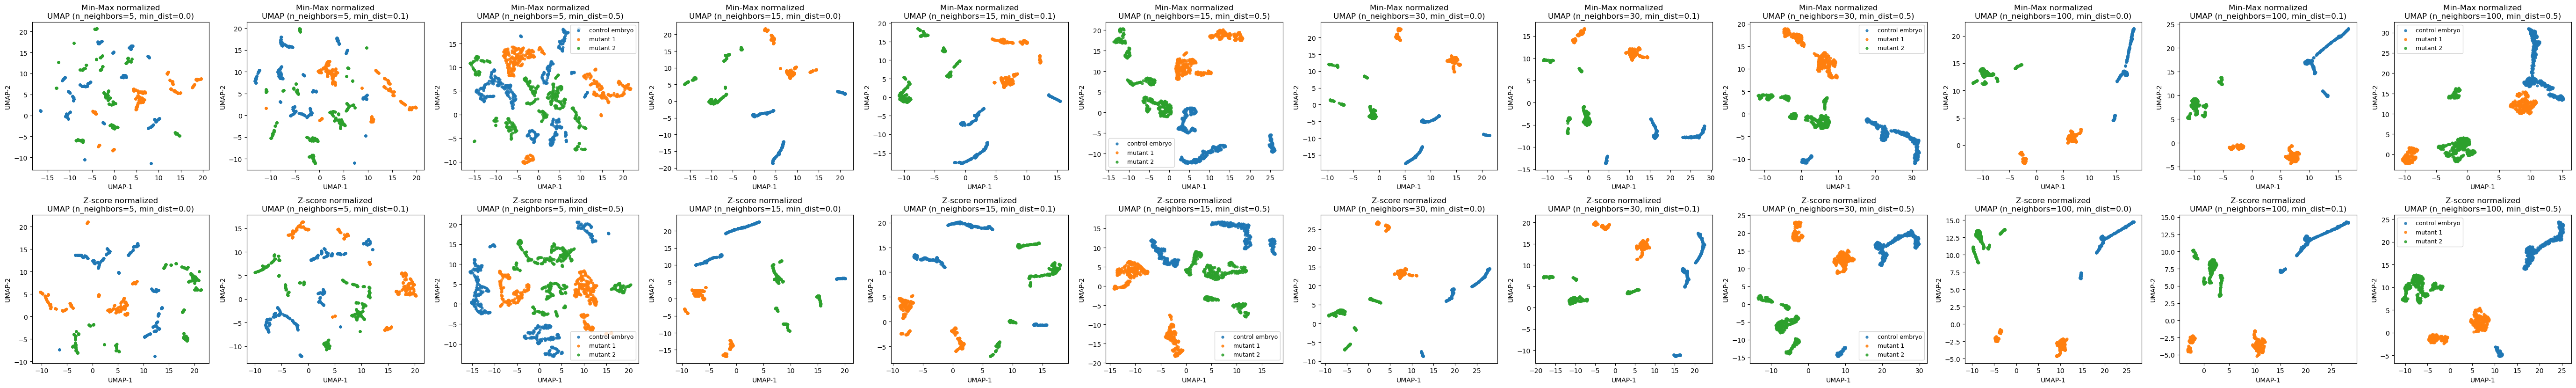

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap
import builtins as _b  # para usar _b.min/_b.max/_b.len aunque los hayas pisado

# ========= Config =========
neighbors_list = [5, 15, 30, 100]
min_dist_list  = [0.0, 0.1, 0.5]
label_names = {0: "control embryo", 1: "mutant 1", 2: "mutant 2"}
colors = ["tab:blue", "tab:orange", "tab:green"]
random_state = 0

# ========= Helpers =========
def safe_pca(X, k=50):
    """Reduce con PCA a lo mucho k comp., sin exceder grados de libertad."""
    n_samples, n_features = X.shape
    n_ok = _b.max(2, _b.min(k, n_samples - 1, n_features))
    return PCA(n_components=n_ok, random_state=random_state).fit_transform(X)

def run_umap(X, n_neighbors=15, min_dist=0.1, rs=0, metric="euclidean"):
    """UMAP 2D con parámetros dados."""
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=int(n_neighbors),
        min_dist=float(min_dist),
        metric=metric,
        random_state=rs,
        n_jobs=-1,          # usa todos los cores disponibles
        verbose=False
    )
    Z = reducer.fit_transform(X)
    return Z

def plot_umap_grid(X_list, titles, y, neighbors_list, min_dist_list):
    rows = _b.len(X_list)
    cols = _b.len(neighbors_list) * _b.len(min_dist_list)
    fig, axes = plt.subplots(rows, cols, figsize=(4.6*cols, 4.2*rows), squeeze=False)

    for r, (X, tname) in enumerate(zip(X_list, titles)):
        # Pre-PCA para acelerar/estabilizar
        Xp = safe_pca(X, k=50)
        col_idx = 0
        for nn in neighbors_list:
            for md in min_dist_list:
                Z = run_umap(Xp, n_neighbors=nn, min_dist=md, rs=random_state)
                ax = axes[r, col_idx]
                for lab in np.unique(y):
                    ax.scatter(
                        Z[y == lab, 0], Z[y == lab, 1],
                        s=12, alpha=0.85,
                        label=label_names[int(lab)],
                        color=colors[int(lab)]
                    )
                ax.set_title(f"{tname}\nUMAP (n_neighbors={nn}, min_dist={md})")
                ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
                if col_idx % (_b.len(min_dist_list)) == (_b.len(min_dist_list)-1):
                    ax.legend(loc="best", fontsize=9)
                col_idx += 1

    plt.tight_layout()
    plt.show()

# ========= Ejecutar =========
X_sets  = [X_minmax, X_zscore]             # mismas matrices que usaste en PCA/t-SNE
titles  = ["Min-Max normalized", "Z-score normalized"]
plot_umap_grid(X_sets, titles, y, neighbors_list, min_dist_list)


## 7. Autoencoder

Train a neural autoencoder to learn a 2D latent space:
- Architecture: `input → 128 → 32 → 2 → 32 → 128 → output`
- Use ReLU activations and MSE loss.
- Plot the latent 2D representations colored by embryo.

> 💡 Autoencoders are flexible nonlinear methods that may capture dynamics not seen by linear projections.


N=1350, n_pixels=40000


2025-09-24 18:01:07.771827: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-09-24 18:01:07.772127: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-24 18:01:07.772141: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-09-24 18:01:07.772397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-24 18:01:07.772426: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-09-24 18:01:09.577162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - loss: 0.1819 - val_loss: 0.0644 - learning_rate: 0.0010
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0628 - val_loss: 0.0311 - learning_rate: 0.0010
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0319 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0302 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0228 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0205 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0197 - val_loss: 0.0196 - learning_rate: 0.0010
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0196 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0192 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0

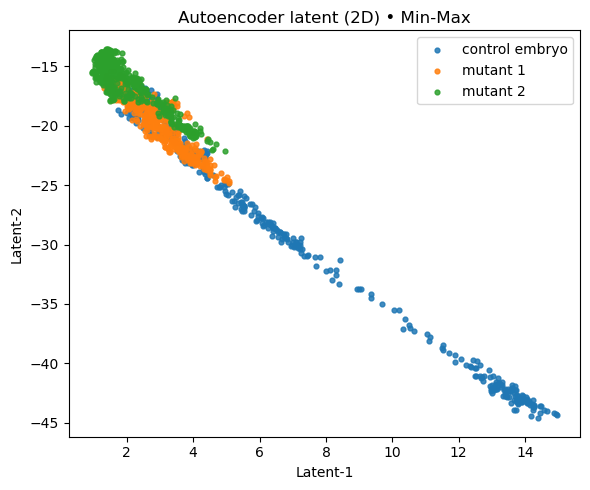

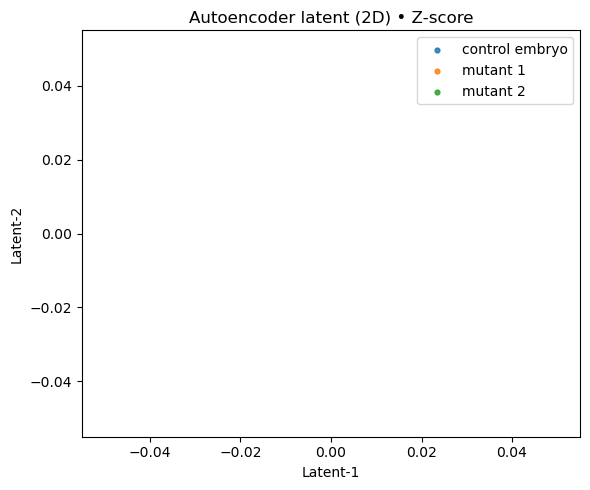

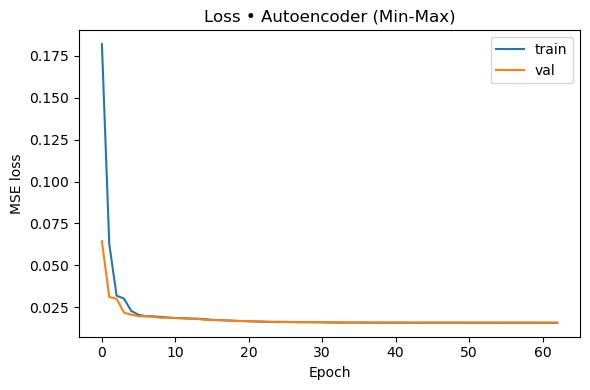

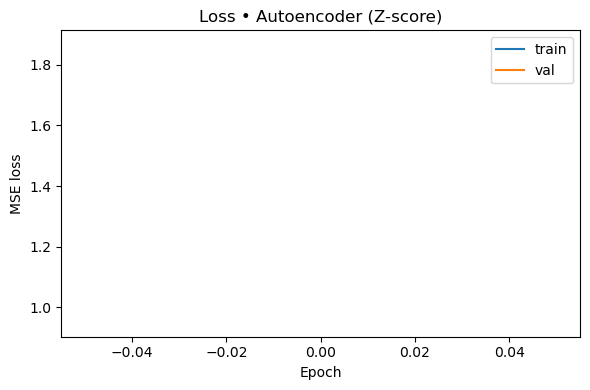

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -------------------------------------------------------
# Config
# -------------------------------------------------------
label_names = {0: "control embryo", 1: "mutant 1", 2: "mutant 2"}
colors = ["tab:blue", "tab:orange", "tab:green"]
random_state = 0
epochs = 100
batch_size = 128
use_pca_preproj = False   # <- ponlo True si n_pixels es enorme

# -------------------------------------------------------
# Datos (ya construidos en pasos previos)
# X_minmax, X_zscore: (N_total_frames, n_pixels)
# y: (N_total_frames,)
# -------------------------------------------------------
N, n_pixels = X_zscore.shape
print(f"N={N}, n_pixels={n_pixels}")

# (Opcional) pre-PCA para reducir dimensiones antes del autoencoder
def maybe_pca(X, k=1024):
    if not use_pca_preproj:
        return X, None
    k_eff = max(8, min(k, X.shape[0]-1, X.shape[1]))
    pca = PCA(n_components=k_eff, random_state=random_state)
    Xp = pca.fit_transform(X)
    return Xp, pca

# -------------------------------------------------------
# Modelo Autoencoder
# -------------------------------------------------------
def build_autoencoder(input_dim):
    inp = keras.Input(shape=(input_dim,))
    # Encoder
    x = layers.Dense(128, activation="relu")(inp)
    x = layers.Dense(32, activation="relu")(x)
    z = layers.Dense(2, activation=None, name="latent_2d")(x)  # lineal para latente 2D
    # Decoder
    x = layers.Dense(32, activation="relu")(z)
    x = layers.Dense(128, activation="relu")(x)
    out = layers.Dense(input_dim, activation="linear")(x)      # salida lineal para MSE
    model = keras.Model(inp, out, name="autoencoder")
    encoder = keras.Model(inp, z, name="encoder")
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")
    return model, encoder

def train_autoencoder(X, test_size=0.2, seed=0, tag=""):
    # Split (barajado por marcos)
    X_tr, X_te = train_test_split(X, test_size=test_size, random_state=seed, shuffle=True)

    model, encoder = build_autoencoder(X.shape[1])
    cb = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, verbose=1)
    ]
    hist = model.fit(
        X_tr, X_tr,
        validation_data=(X_te, X_te),
        epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1, callbacks=cb
    )
    print(f"[{tag}] best val_loss = {np.min(hist.history['val_loss']):.6f}")
    Z = encoder.predict(X, batch_size=batch_size, verbose=0)  # latente 2D de todo el set
    return model, encoder, Z, hist

def plot_latent(Z, y, title):
    plt.figure(figsize=(6,5))
    for lab in np.unique(y):
        plt.scatter(
            Z[y==lab, 0], Z[y==lab, 1],
            s=12, alpha=0.85, label=label_names[int(lab)], color=colors[int(lab)]
        )
    plt.xlabel("Latent-1")
    plt.ylabel("Latent-2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------
# Entrenar en Min-Max
# -------------------------------------------------------
Xmm_in, pca_mm = maybe_pca(X_minmax, k=1024)
ae_mm, enc_mm, Z_mm, hist_mm = train_autoencoder(Xmm_in, seed=random_state, tag="Min-Max")

# -------------------------------------------------------
# Entrenar en Z-score
# -------------------------------------------------------
Xzs_in, pca_zs = maybe_pca(X_zscore, k=1024)
ae_zs, enc_zs, Z_zs, hist_zs = train_autoencoder(Xzs_in, seed=random_state, tag="Z-score")

# -------------------------------------------------------
# Graficar latentes
# -------------------------------------------------------
plot_latent(Z_mm, y, "Autoencoder latent (2D) • Min-Max")
plot_latent(Z_zs, y, "Autoencoder latent (2D) • Z-score")

# -------------------------------------------------------
# (Opcional) Curvas de entrenamiento
# -------------------------------------------------------
def plot_losses(hist, title):
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["loss"], label="train")
    plt.plot(hist.history["val_loss"], label="val")
    plt.title(title)
    plt.xlabel("Epoch"); plt.ylabel("MSE loss")
    plt.legend(); plt.tight_layout(); plt.show()

plot_losses(hist_mm, "Loss • Autoencoder (Min-Max)")
plot_losses(hist_zs, "Loss • Autoencoder (Z-score)")


## 8. Final Reflection

Write a short report answering the following:

1. What differences in developmental dynamics did you observe?
2. Which method best captured biologically relevant features?
3. Which normalization (Min-Max or StandardScaler) led to better embeddings?
4. At which point do mutant trajectories diverge from normal?
5. How consistent were the results across methods (PCA, t-SNE, UMAP, Autoencoders)?

> 📝 Submit this as a 1-page summary or short presentation.
